<h1 align=center><font size = 6>Lemon Quality Classification with Class Activation Map</font></h1>
<br>
<img src="https://cdn.britannica.com/84/188484-050-F27B0049/lemons-tree.jpg" height=450 width=1000 alt="britannica.com">
<small>Picture Source:<a href="https://cdn.britannica.com/84/188484-050-F27B0049/lemons-tree.jpg"> britannica</a>

<br>

<h2>Description</h2>
<p>Lemon dataset has been prepared to investigate the possibilities to tackle the issue of fruit quality control. It contains <i>2.533</i> images <i>(300 x 300 pixels)</i>. Lemon images are taken on a concrete surface. Dataset also includes empty images of this surface.

Dataset contains images of both bad and good quality lemons under slightly different lighting conditions (all under daylight) and sizes.</p>

<br>

<h2>Acknowledgements</h2>
<p>This dataset has been referred from <a href="https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset">Kaggle</a>.</p>
<br>
<h2>Objective:</h2>
<ul>
  <li>Understand the dataset & cleanup (if required).</li>
  <li>Build classification models to predict the lemon class.</li>
  <li>Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.</li>
  <li>Build class activation maps (CAM).</li>
</ul>

<br>
<h2>Keywords</h2>
<ul>
  <li>Computer Science</li>
  <li>Classification</li>
  <li>Biology</li>
  <li>Class Activation Map</li>
  <li>Neural Networks</li>
  <li>Lemons</li>
</ul>
<br>

<h2>Objective for this Notebook</h2>

<p>Within the scope of this project, a classification model was builded whether lemons have good quality, bad quality or empty through data obtained from <b>Yusuf Emir Köroğlu</b>.</p>
<div class="alert alert-block alert-info" style="margin-top: 20px">

<li><a href="https://#import">Import Libraries and Packages</a></li>
<li><a href="https://#data_preparation">Dataset Preparation</a></li>
<li><a href="https://#compile_fit">Compile and Fit the Model</a></li>
<li><a href="https://#build_cam">Building Class Activation Maps</a></li>
<li><a href="https://#make_dataframe">Make Dataframe for the Predictions</a></li>
<li><a href="https://#upload_predict">Upload and Predict Your Picture!</a></li>
<br>

<p></p>
Estimated Time Needed: <strong>30 min</strong>
</div>

In [ ]:
!unzip -q archive.zip

<br>
<h2 align=center id="import">Import Libraries and Packages</h2>
<p>The following are the libraries we are going to use for this lab:</p>

In [ ]:
#from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import seaborn as sns

In [ ]:
import os
import shutil

In [ ]:
import datetime

<br>
<h2 align=center id="data_preparation">Dataset Preparation</h2>

<p>We are going to separate our dataset.</p>

In [ ]:
num_classes = 3
image_resize = 224
batch_size_training = 128
batch_size_validation = 128

In [ ]:
data_generator = ImageDataGenerator()

In [ ]:
def train_test_split():
    print("SPLITTING STARTED")
    #data_csv = pd.read_csv("DataSet_Final.csv") ##Use if you have classes saved in any .csv file

    root_dir = '/content/'
    classes_dir = ['bad_quality', 'good_quality', 'empty_background']

    #for name in data_csv['names'].unique()[:10]:
    #    classes_dir.append(name)

    processed_dir = '/content/lemon_dataset'

    val_ratio = 0.10
    test_ratio = 0.20

    for cls in classes_dir:
        # Creating partitions of the data after shuffeling
        print("\n Class Name " + cls)
        src = processed_dir +"//" + cls  # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])

        train_FileNames = [src + '//' + name for name in train_FileNames.tolist()]
        val_FileNames = [src + '//' + name for name in val_FileNames.tolist()]
        test_FileNames = [src + '//' + name for name in test_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Validation: '+  str(len(val_FileNames)))
        print('Testing: '+ str(len(test_FileNames)))

        # # Creating Train / Val / Test folders (One time use)
        os.makedirs(root_dir + '/train//' + cls)
        os.makedirs(root_dir + '/val//' + cls)
        os.makedirs(root_dir + '/test//' + cls)

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + '/train//' + cls)

        for name in val_FileNames:
            shutil.copy(name, root_dir + '/val//' + cls)

        for name in test_FileNames:
            shutil.copy(name, root_dir + '/test//' + cls)

    print("SPLITTING ENDED")

train_test_split()

SPLITTING STARTED

 Class Name bad_quality
Total images: 951
Training: 665
Validation: 190
Testing: 96

 Class Name good_quality
Total images: 1125
Training: 787
Validation: 225
Testing: 113

 Class Name empty_background
Total images: 452
Training: 316
Validation: 90
Testing: 46
SPLITTING ENDED


In [ ]:
TEST_PATH = '/content/test'
TRAIN_PATH = '/content/train'
VALID_PATH = '/content/val'

In [ ]:
train_generator = data_generator.flow_from_directory(
  TRAIN_PATH,
  target_size=(image_resize, image_resize),
  batch_size=batch_size_training,
  class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
  VALID_PATH,
  target_size=(image_resize, image_resize),
  batch_size=batch_size_validation,
  class_mode='categorical')

Found 1768 images belonging to 3 classes.
Found 505 images belonging to 3 classes.


In [ ]:
first_batch = train_generator.next()
first_batch

(array([[[[156., 155., 150.],
          [177., 176., 171.],
          [174., 173., 168.],
          ...,
          [141., 138., 131.],
          [142., 139., 132.],
          [146., 143., 136.]],
 
         [[173., 172., 167.],
          [177., 176., 171.],
          [177., 176., 171.],
          ...,
          [147., 144., 137.],
          [149., 146., 139.],
          [143., 140., 133.]],
 
         [[173., 172., 167.],
          [178., 177., 172.],
          [174., 173., 168.],
          ...,
          [144., 141., 134.],
          [145., 142., 135.],
          [139., 136., 129.]],
 
         ...,
 
         [[168., 169., 164.],
          [163., 164., 159.],
          [169., 170., 165.],
          ...,
          [ 95.,  96.,  91.],
          [ 96.,  97.,  92.],
          [102., 103.,  98.]],
 
         [[178., 179., 174.],
          [180., 181., 176.],
          [173., 174., 169.],
          ...,
          [ 99., 100.,  95.],
          [ 98.,  99.,  94.],
          [ 98.,  99.,  94.

In [ ]:
first_batch_images = train_generator.next()[0]
first_batch_images

array([[[[145., 147., 136.],
         [149., 150., 142.],
         [143., 144., 136.],
         ...,
         [162., 167., 160.],
         [168., 173., 166.],
         [160., 165., 158.]],

        [[154., 156., 145.],
         [149., 150., 142.],
         [147., 148., 140.],
         ...,
         [156., 161., 154.],
         [157., 162., 155.],
         [170., 175., 168.]],

        [[150., 152., 141.],
         [142., 144., 133.],
         [139., 140., 132.],
         ...,
         [148., 153., 146.],
         [148., 153., 146.],
         [165., 170., 163.]],

        ...,

        [[125., 125., 117.],
         [124., 125., 117.],
         [127., 128., 120.],
         ...,
         [106., 106.,  94.],
         [128., 128., 116.],
         [140., 140., 128.]],

        [[144., 144., 136.],
         [135., 135., 127.],
         [139., 140., 132.],
         ...,
         [115., 115., 103.],
         [150., 150., 138.],
         [166., 166., 154.]],

        [[147., 147., 139.],
       

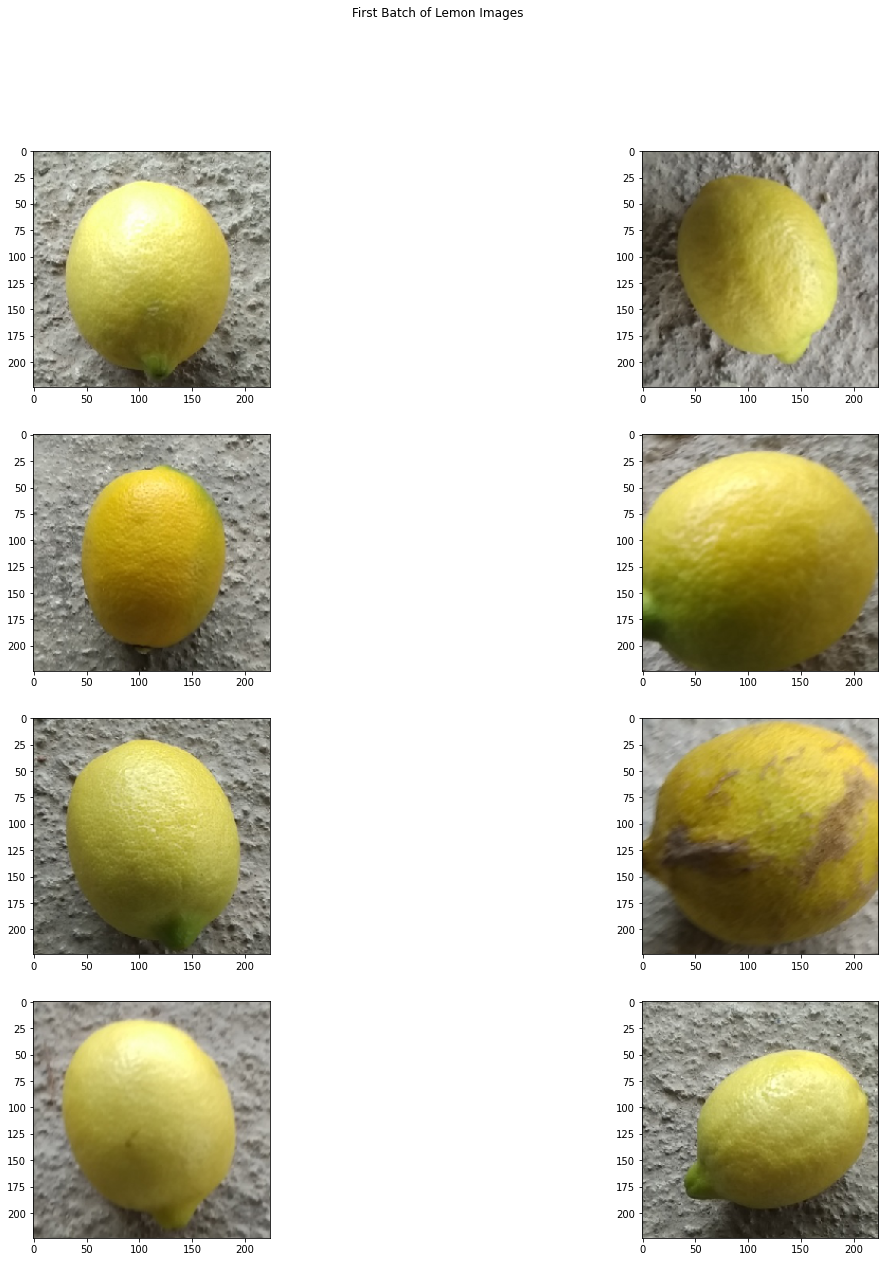

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 20)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1: 
        #image_data = first_batch_images[ind]
        image_data = first_batch_images[ind].astype(np.uint8)
        #ax2.imshow((image_data * 255).astype(np.uint8))
        ax2.imshow(image_data, cmap = "gray")
        ind += 1

fig.suptitle('First Batch of Lemon Images') 
plt.show()

<br>
<h2 align=center id="compile_fit">Compile and Fit the Model</h2>

In [ ]:
#load_model('/content/model.h5')

In [ ]:
def define_model(input_shape, num_classes):
 
  model = Sequential([
    
    layers.Conv2D(16, input_shape=(image_resize, image_resize, 3), kernel_size=(3,3),activation='relu',padding='same'),        
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
  
  ])
  model.summary()
  
  return model

In [ ]:
model = define_model(224, 3) # 224x224 as pixels and 3 as lemon classes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
model.fit(train_generator, epochs=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/32
14/14 [==============================] - 105s 7s/step - loss: 25.2690 - accuracy: 0.3891
Epoch 2/32
14/14 [==============================] - 100s 7s/step - loss: 1.3955 - accuracy: 0.4893
Epoch 3/32
14/14 [==============================] - 96s 7s/step - loss: 0.9088 - accuracy: 0.5633
Epoch 4/32
14/14 [==============================] - 97s 7s/step - loss: 1.1668 - accuracy: 0.6391
Epoch 5/32
14/14 [==============================] - 99s 7s/step - loss: 0.8185 - accuracy: 0.7019
Epoch 6/32
14/14 [==============================] - 97s 7s/step - loss: 1.1602 - accuracy: 0.6131
Epoch 7/32
14/14 [==============================] - 96s 7s/step - loss: 0.6622 - accuracy: 0.7223
Epoch 8/32
14/14 [==============================] - 99s 7s/step - loss: 0.6191 - accuracy: 0.6974
Epoch 9/32
14/14 [==============================] - 97s 7s/step - loss: 0.7848 - accuracy: 0.7104
Epoch 10/32
14/14 [==============================] - 96s 7s/step - loss: 0.5977 - accuracy: 0.7562
Epoch 11/32
14/1

In [ ]:
model.save("model.h5")
print("Model saved!")

Model saved!


<br>
<h2 align=center id="build_cam">Building Class Activation Maps</h2>

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input, outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496 

In [ ]:
class_mapping = train_generator.class_indices
class_mapping

{'bad_quality': 0, 'empty_background': 1, 'good_quality': 2}

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 224 x 224
    features (array) -- features of the image, shape (1, 28, 28, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (224/28, 224/28, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'Output \nBad quality: {results[0][0]} \nEmpty: {results[0][1]} \nGood quality: {results[0][2]}')
  plt.figure(figsize=(8, 8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()
  

In [ ]:
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (224, 224)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

1/1 [==============================] - 0s 34ms/step
Output 
Bad quality: 0.3771207928657532 
Empty: 0.3149782419204712 
Good quality: 0.30790096521377563


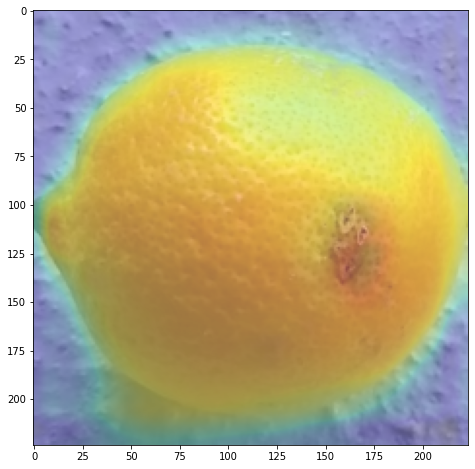

In [ ]:
convert_and_classify('/content/test/bad_quality/bad_quality_548.jpg')

1/1 [==============================] - 0s 37ms/step
Output 
Bad quality: 0.1380969136953354 
Empty: 0.45847946405410767 
Good quality: 0.403423547744751


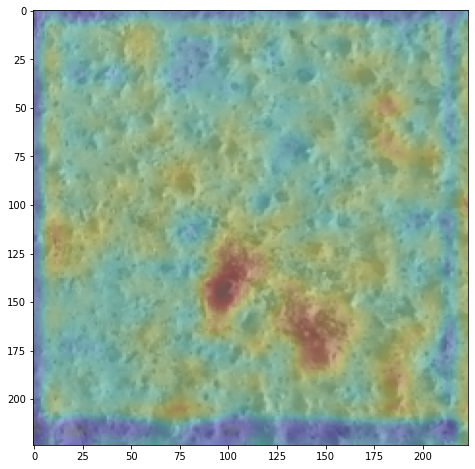

In [ ]:
convert_and_classify('/content/test/empty_background/empty_background_370.jpg')

1/1 [==============================] - 0s 57ms/step
Output 
Bad quality: 0.24130874872207642 
Empty: 0.39747506380081177 
Good quality: 0.3612162470817566


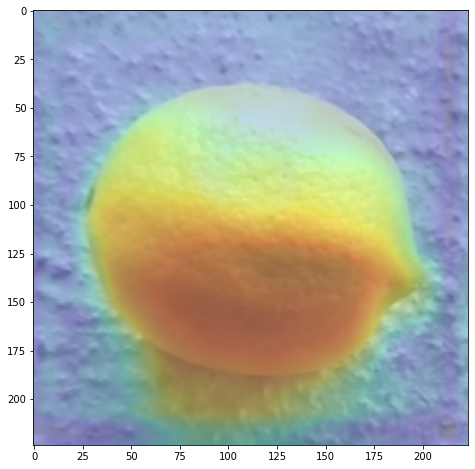

In [ ]:
convert_and_classify('/content/test/good_quality/good_quality_71.jpg')

<br>
<h2 align=center id="make_dataframe">Make Dataframe for the Predictions</h2>

In [ ]:
test_generator = data_generator.flow_from_directory(
  TEST_PATH,
  target_size=(image_resize, image_resize),
  shuffle=False,
  class_mode='categorical')

Found 255 images belonging to 3 classes.


In [ ]:
filenames=test_generator.filenames

In [ ]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1).round(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


8/8 [==============================] - 5s 615ms/step


In [ ]:
filenames_df = pd.DataFrame(filenames, columns=['File Path'])
pred_df = pd.DataFrame(pred, columns=['Bad Quality Probability', 'Background Probability','Good Quality Probability'])
model_predictions = pd.concat([filenames_df, pred_df], axis=1)
model_predictions

,File Path,Bad Quality Probability,Background Probability,Good Quality Probability
0,bad_quality/bad_quality_100.jpg,0.707,0.000,0.293
1,bad_quality/bad_quality_110.jpg,1.000,0.000,0.000
2,bad_quality/bad_quality_116.jpg,0.701,0.000,0.299
3,bad_quality/bad_quality_12.jpg,0.907,0.000,0.093
4,bad_quality/bad_quality_122.jpg,0.091,0.001,0.908
...,...,...,...,...
250,good_quality/good_quality_962.jpg,0.007,0.000,0.993
251,good_quality/good_quality_977.jpg,0.000,0.000,1.000
252,good_quality/good_quality_982.jpg,0.003,0.000,0.997
253,good_quality/good_quality_992.jpg,0.000,0.000,1.000


In [ ]:
file_name='model_predictions.csv'
model_predictions.to_csv(file_name, sep=',', encoding='utf-8')

<br>
<h2 align=center id="upload_predict">Upload and Predict Your Picture!</h2>

In [ ]:
from google.colab import files
from keras.preprocessing import image
from numpy import asarray

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  width = 224
  height = 224
  dim = (width, height)
  path = '/content/' + fn
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, dim)
  x = asarray(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print("Bad quality: %", round(classes[0][0]*100, 2))
  print("Empty: %", round(classes[0][1]*100, 2))
  print("Good quality: %", round(classes[0][2]*100, 2))

Saving Lemon.jpg to Lemon.jpg
1/1 [==============================] - 0s 33ms/step
Bad quality: % 71.71
Empty: % 0.0
Good quality: % 28.29


<h1>Contact Me</h1>
<p>If you have something to say to me please contact me:</p>

<ul>
  <li>Twitter: <a href="https://twitter.com/Doguilmak">Doguilmak</a></li>
  <li>Mail address: doguilmak@gmail.com</li>
</ul>

In [2]:
from datetime import datetime
print(f"Changes have been made to the project on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Changes have been made to the project on 2022-11-01 11:17:28
